In [1]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn as nn
import gc
import numpy as np
import logging
from torch.cuda.amp import autocast
# for mixed precision to reduce memory usage on compatible GPUs
from sklearn.model_selection import train_test_split
from transformers import XLMRobertaTokenizer, XLMRobertaModel

In [2]:
# pip install sentencepiece

In [3]:
model_name = "xlm-roberta-base"
tokenizer = XLMRobertaTokenizer.from_pretrained(model_name)
model_original = XLMRobertaModel.from_pretrained(model_name)

In [4]:
from transformers import XLMRobertaForMaskedLM
model_path = r"D:\\CJ\\course\\大四下\\final project\ARO\ARO Intelligent\\preparation\\model\\xlm_trained_model"

# Reload model and tokenizer
model_trained = XLMRobertaForMaskedLM.from_pretrained(model_path)

In [5]:
batch_size = 32

# extract embeddings
def get_embeddings(model, texts, max_length=512):


    model.eval()  # set model to evaluation mode
    embeddings = []

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            inputs = tokenizer(batch_texts, return_tensors='pt', max_length=max_length, truncation=True, padding='max_length')
            # Mixed precision context to reduce memory usage on GPUs that support it
            with autocast():
                outputs = model(**inputs, output_hidden_states=True)
                # batch_embeddings = outputs.last_hidden_state.mean(dim=1)  # use mean pooling
                # For the ForMaskedLM model, outputs.base_model_output.last_hidden_state should be used to access the last hidden state
                hidden_states = outputs.hidden_states
                last_hidden_state = hidden_states[-1]
                # Calculate the mean of the hidden states of the last layer
                batch_embeddings = last_hidden_state.mean(dim=1)
            embeddings.append(batch_embeddings)
            del inputs, outputs, batch_embeddings  # Free up memory
            gc.collect()


    embeddings_tensor = torch.cat(embeddings, dim=0)
    return embeddings_tensor


In [6]:
import torch
import torch.nn.functional as F
import numpy as np
from transformers import XLMRobertaTokenizer


keyword = "bull is a kind of animal" 

# Get embeddings for the keyword
keyword_embeddings_original = get_embeddings(model_original, [keyword])

# Normalize embeddings
keyword_embeddings_original = F.normalize(keyword_embeddings_original, p=2, dim=1)


In [7]:
import torch
import torch.nn.functional as F

similar_words_original_1 = ["bull", "tarbh", "cattle", "crodh", "cowe", "cow", "calf", "coo", "ox", "oxen", "human", "model"]
similar_words_original_2 = [f"Williame futhes ane pece of wastlande liande one the Est part of Sanct nicholes kirkyard mercheand' with the lande that vmquhill Williame bull Inhabit to big ane berne he payand' xij d' yerlie to the communite Ande ordanit to mak him ane chartir tharupon' heritablie vndir thar common' Sell"]
similar_words_original_3 = [f"In Dulmayek to giddir with xxiiij ky and ane bull in collangy to vpbringe hir' and mary hir' befor the saide witnes and notar"]
# Use the same function to extract embeddings for similar words
similar_embeddings_original_1 = get_embeddings(model_original, similar_words_original_1)
similar_embeddings_original_2 = get_embeddings(model_original, similar_words_original_2)
similar_embeddings_original_3 = get_embeddings(model_original, similar_words_original_3)

# similar_words_original_1 = F.normalize(similar_words_original_1, p=2, dim=1)
# similar_words_original_2 = F.normalize(similar_words_original_2, p=2, dim=1)
# similar_words_original_3 = F.normalize(similar_words_original_3, p=2, dim=1)

# Calculate similarity
# cosine_similarity in PyTorch calculates the similarity in the last dimension by default, so reshape is not needed
similarities_original_1 = F.cosine_similarity(keyword_embeddings_original.unsqueeze(0), similar_embeddings_original_1.unsqueeze(0), dim=2)
similarities_original_2 = F.cosine_similarity(keyword_embeddings_original.unsqueeze(0), similar_embeddings_original_2.unsqueeze(0), dim=2)
similarities_original_3 = F.cosine_similarity(keyword_embeddings_original.unsqueeze(0), similar_embeddings_original_3.unsqueeze(0), dim=2)

print(similarities_original_1, "\n", similarities_original_2, "\n", similarities_original_3)


tensor([[0.9978, 0.9226, 0.9949, 0.9237, 0.9185, 0.9132, 0.9976, 0.9218, 0.9974,
         0.9265, 0.9977]]) 
 tensor([[0.9577]]) 
 tensor([[0.9469]])


In [8]:
import torch
import torch.nn.functional as F
import numpy as np
from transformers import XLMRobertaTokenizer


keyword = "bull is a kind of animal" 

# Get embeddings for the keyword
keyword_embeddings_trained = get_embeddings(model_trained, [keyword])

# Normalize embeddings
keyword_embeddings_trained = F.normalize(keyword_embeddings_trained, p=2, dim=1)

In [12]:
import torch
import torch.nn.functional as F

similar_words_trained_1 = ["bull", "tarbh", "cattle", "crodh", "cowe", "cow", "calf", "coo", "oxen", "human", "model"]
similar_words_trained_2 = [f"Williame futhes ane pece of wastlande liande one the Est part of Sanct nicholes kirkyard mercheand' with the lande that vmquhill Williame bull Inhabit to big ane berne he payand' xij d' yerlie to the communite Ande ordanit to mak him ane chartir tharupon' heritablie vndir thar common' Sell"]
similar_words_trained_3 = [f"In Dulmayek to giddir with xxiiij ky and ane bull in collangy to vpbringe hir' and mary hir' befor the saide witnes and notar"]

# Use the same function to extract embeddings for similar words
similar_embeddings_trained_1 = get_embeddings(model_trained, similar_words_trained_1)
similar_embeddings_trained_2 = get_embeddings(model_trained, similar_words_trained_2)
similar_embeddings_trained_3 = get_embeddings(model_trained, similar_words_trained_3)

# similar_embeddings_trained_1 = F.normalize(similar_embeddings_trained_1, p=2, dim=1)
# similar_embeddings_trained_2 = F.normalize(similar_embeddings_trained_2, p=2, dim=1)
# similar_embeddings_trained_3 = F.normalize(similar_embeddings_trained_3, p=2, dim=1)

# Calculate similarity
# cosine_similarity in PyTorch calculates the similarity in the last dimension by default, so reshape is not needed
similarities_trained_1 = F.cosine_similarity(keyword_embeddings_trained.unsqueeze(0), similar_embeddings_trained_1.unsqueeze(0), dim=2)
similarities_trained_2 = F.cosine_similarity(keyword_embeddings_trained.unsqueeze(0), similar_embeddings_trained_2.unsqueeze(0), dim=2)
similarities_trained_3 = F.cosine_similarity(keyword_embeddings_trained.unsqueeze(0), similar_embeddings_trained_3.unsqueeze(0), dim=2)

print(similarities_trained_1, "\n", similarities_trained_2, "\n", similarities_trained_3)

tensor([[0.9982, 0.9827, 0.9969, 0.9976, 0.9967, 0.9973, 0.9930, 0.9144, 0.9901,
         0.8567, 0.5540]]) 
 tensor([[0.9903]]) 
 tensor([[0.9958]])


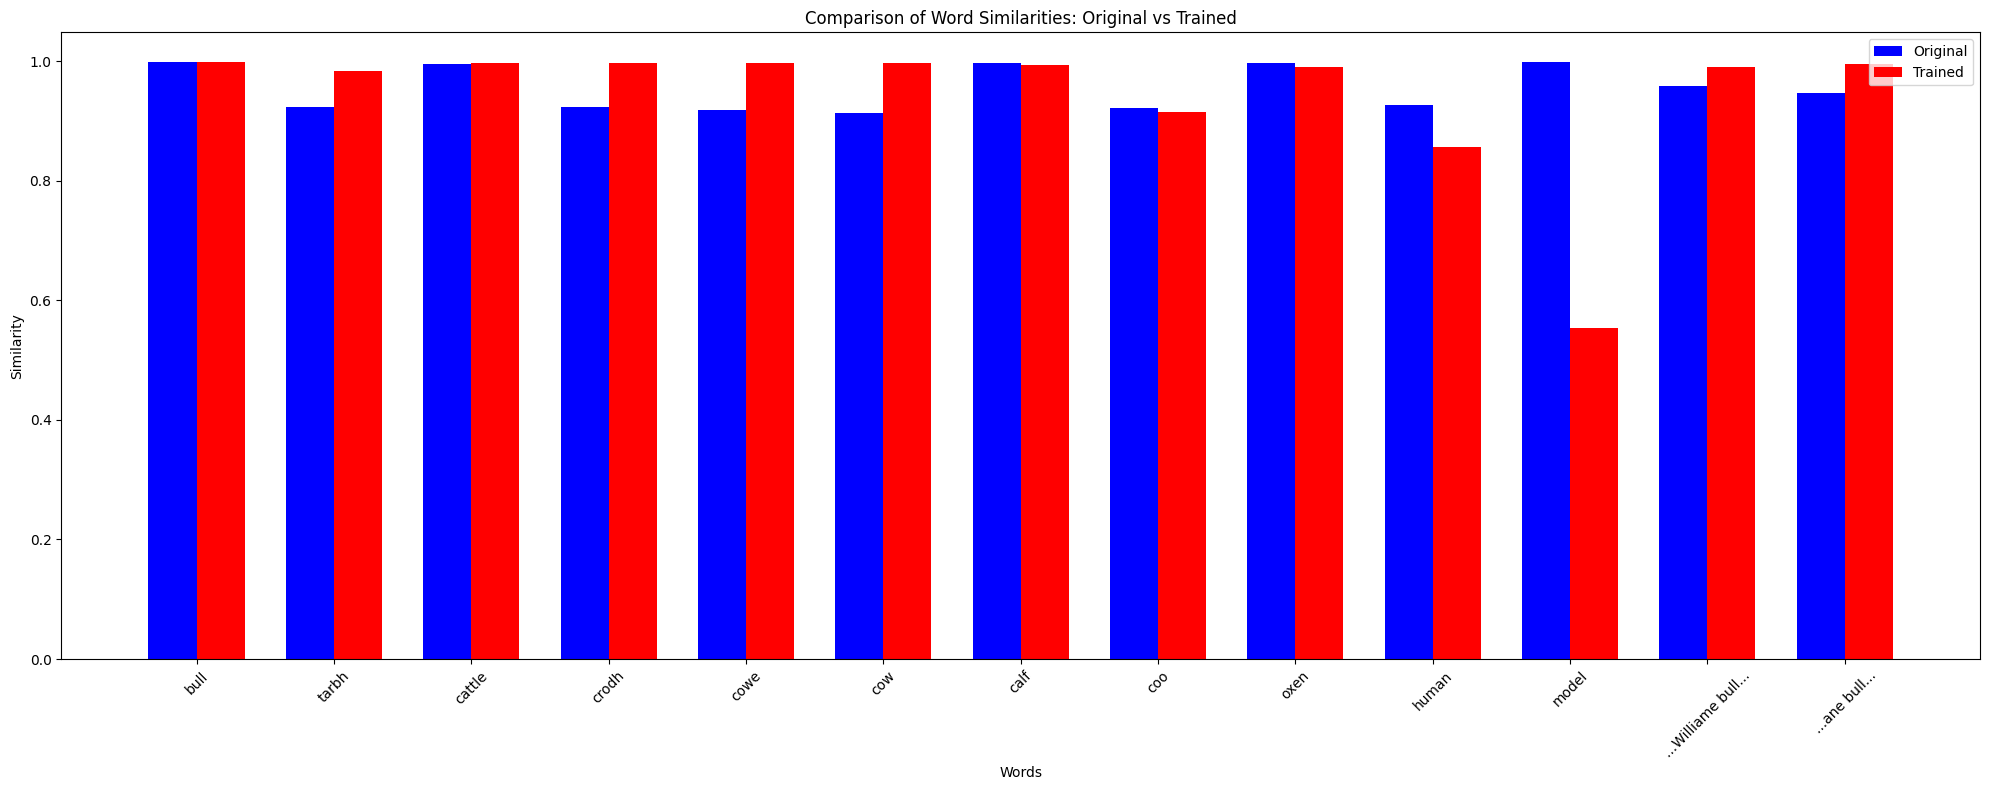

In [18]:
import matplotlib.pyplot as plt
import numpy as np

similarities_original = [similarities_original_1, similarities_original_2, similarities_original_3]
similarities_trained = [similarities_trained_1, similarities_trained_2, similarities_trained_3]

# Assuming the similarities are already available as NumPy arrays or can be easily converted:
# Convert tensor data to numpy arrays directly, if they are tensors, otherwise assume they are already numpy arrays or lists
similarities_original = [s.numpy().flatten() for s in similarities_original]
similarities_trained = [s.numpy().flatten() for s in similarities_trained]

# Flatten similarities for plotting
original_flat = np.concatenate(similarities_original)
trained_flat = np.concatenate(similarities_trained)


similar_words_original_2 = ["...Williame bull..."]
similar_words_original_3 = ["...ane bull..."]
# Define labels for each group based on the word lists
labels = similar_words_original_1 + similar_words_original_2 + similar_words_original_3

# Setup for grouped bar chart
n_groups = len(original_flat)
index = np.arange(n_groups)  # Array of indices for each group
bar_width = 0.35  # Width of bars

fig, ax = plt.subplots(figsize=(20, 8))

# Plotting original and trained similarities
bars1 = ax.bar(index - bar_width/2, original_flat, bar_width, label='Original', color='b')
bars2 = ax.bar(index + bar_width/2, trained_flat, bar_width, label='Trained', color='r')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Words')
ax.set_ylabel('Similarity')
ax.set_title('Comparison of Word Similarities: Original vs Trained')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

